In [1]:
__author__ = '8372'

import time
import logging
import optparse
import numpy as np
import pandas as pd
from config_back import *
import exifutil
import torch

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [ ]:
# TO DO: Check if all file exists, else don't let the model through

class ModelClassifier(object):
    def __init__(self, model_def_file, pretrained_model_file, mean_file,
                 raw_scale, class_labels_file, image_dim, gpu_mode):
        logging.info('Loading net and associated files...')
        
#         if gpu_mode:
#             caffe.set_mode_gpu()
#             caffe.set_device(1)
#         else:
#             caffe.set_mode_cpu()
            
        self.net = caffe.Classifier(
            model_def_file, pretrained_model_file,
            image_dims=(image_dim, image_dim), raw_scale=raw_scale,
            mean=np.load(mean_file).mean(1).mean(1), channel_swap=(2, 1, 0)
        )

        with open(class_labels_file) as f:
            labels_df = pd.DataFrame([
                                         {
                                             'id': l.strip().split(' ')[0][1:],
                                             # The [1:] to get rid of 'n' in labels of the format n<label_id>
                                             'name': ' '.join(l.strip().split(' ')[1:]).split(',')[0]
                                         }
                                         for l in f.readlines()
                                         ])
            labels_df = labels_df.convert_objects(convert_numeric=True)
        self.labels = labels_df.sort('id')['name'].values

    def classify_image(self, image):
        try:
            starttime = time.time()
            scores = self.net.predict([image], oversample=True).flatten()
            endtime = time.time()

            indices = (-scores).argsort()[:1]
            predictions = self.labels[indices]

            # In addition to the prediction text, we will also produce
            # the length for the progress bar visualization.
            meta = [
                (p, '%.5f' % scores[i])
                for i, p in zip(indices, predictions)
                ]
            logging.info('result: %s', str(meta))

            return True, meta, '%.3f' % (endtime - starttime)

        except Exception as err:
            logging.info('Classification error: %s', err)
            return (False, 'Something went wrong when classifying the '
                           'image. Maybe try another one?')

In [ ]:
def get_conf_matrix(model):

    labels = model.labels.tolist()
    len_labels = len(labels)
    confident_confusion_mat = np.zeros((len_labels, len_labels), dtype=np.int)
    confusion_mat = np.zeros((len_labels, len_labels), dtype=np.int)
    unclassified_list = []
    back_classified_list = []
    frontal_classified_list = []

    test_file_path = MODEL_PATH_DICT['fileMapPath']
    map_df = pd.read_csv(test_file_path, header=None, names=['style_id', 'tag', 'url', 'path'])
    full_list = map_df['path'].tolist()
    test_list = full_list
    map_df['pose']=''
    map_df['pose_conf'] = 0.0
    print len(test_list)
    tracker = 0
    for filename in test_list:
	tracker += 1
	logging.info(str(tracker)+'/'+str(len(test_list)))
        try :
            image = caffe.io.load_image(filename)
	except Exception as e:
            print e.message
            print "ERROR:" + filename
            continue

        result = model.classify_image(image)
        if result[0]:  # Status
            top_result = result[1][0]
            label = top_result[0]
            conf = float(top_result[1])
	    map_df.set_value(full_list.index(filename), 'pose', label)
	    map_df.set_value(full_list.index(filename), 'pose_conf', conf)
    map_df = map_df[~map_df['pose_conf'].isin([0.0])]
    map_df.to_csv('kids_dresses_full_filemap_pose.csv', columns=['style_id', 'tag', 'url', 'path', 'pose', 'pose_conf'],index=False)
    return True

In [2]:
from __future__ import print_function, division

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import json
import cv2
from tqdm import tqdm
import pandas as pd
from datetime import datetime
import ImageFileList
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
article_type = 'dresses'
attribute = 'length'
train_file_name = article_type + '_' + attribute + '_train_shuffled.txt'
test_file_name = article_type + '_' +  attribute + '_test.txt'

#ImageFileList = ImageFileList.ImageFileList()
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_val_list = ['train' , 'val']
# data_dir = 'hymenoptera_data'
path_to_input_file = {
    'train' :'/data2/image_attributes/data/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/' + train_file_name ,
    'val': '/data2/image_attributes/data/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/' + test_file_name
    }
path_to_checkpoint = '/data2/image_attributes/data/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/checkpoints'

image_datasets = {x: ImageFileList.ImageFilelisit_a( flist=path_to_input_file[x],
                                   transform = data_transforms[x])
                  for x in train_val_list}


train_list = image_datasets['train'].imlist
test_list = image_datasets['val'].imlist
train_labels = list(set( [x[1] for x in train_list]))
test_labels = list(set( [x[1] for x in test_list]))
print ('train_labels' + str (train_labels) )
print ('test_labels' + str (train_labels) )
'''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
'''
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in train_val_list}

train_labels[0, 1, 2, 3]
test_labels[0, 1, 2, 3]


In [28]:
article_type, attribute = 'dresses', 'length'
model_dir = '/data2/image_attributes/data/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/'
model_file = 'checkpoints/epoch_16_checkpoint.pth.tar'
model_path = os.path.join(model_dir, model_file )
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features
n_classes = len(train_labels)
model_ft.fc = nn.Linear(num_ftrs, n_classes)
#model_ft.cuda()
checkpoint = torch.load(model_path)
epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

In [29]:
model_ft

AttributeError: 'ResNet' object has no attribute 'classes'

In [5]:
val_images = [x[0] for x in test_list[:10]]
val_labels = [x[1] for x in test_list[:10]]
# val_images_dir = '/data2/image_attributes/data/myntra_data/' + article_type + '/' + \
# article_type + '_' + attribute + '/' + 'val_images' + '/'

# for image, label in tqdm(zip(val_images,val_labels)):
#     print (image)
#     img = cv2.imread(image)
#     image_name = os.path.split(image)[-1]
#     image_path = os.path.join(val_images_dir, image_name)
#     cv2.imwrite(image_path, img)

In [50]:
imsize = 256
# loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
loader = data_transforms['val']
from PIL import Image
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image.show()
#     image = cv2.imread(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader(val_images[6])
outputs = model_ft(image)
print (outputs.data)
_, preds = torch.max(outputs.data, 1)
# preds = preds[0]
preds


-1.1968  1.9771  1.8168 -1.2766
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]




 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [49]:
list1 = [9, 0 ,"a", ["b","c"]]

list1[3][1]

'c'

In [48]:
val_images[6]

'/data2/image_attributes/data/myntra_data/dresses/dresses_images/1054084.jpg'

In [26]:
model_ft

OrderedDict([('conv1.weight', 
              (0 ,0 ,.,.) = 
               -0.0191  0.0036 -0.0479  ...   0.0324 -0.0285 -0.0201
               -0.0134  0.0185 -0.0279  ...  -0.0246 -0.0446 -0.0229
                0.0155  0.0034 -0.0279  ...  -0.0675 -0.0772 -0.0484
                         ...             ⋱             ...          
                0.0085 -0.0847 -0.0628  ...  -0.0026 -0.0071 -0.0204
               -0.0200 -0.0133 -0.0341  ...   0.0172  0.0159 -0.0598
               -0.0103 -0.0373  0.0128  ...  -0.0257 -0.0088 -0.0240
              
              (0 ,1 ,.,.) = 
                0.0198 -0.0010  0.0082  ...   0.0156  0.0567  0.0253
               -0.0172 -0.0454  0.0078  ...   0.0138  0.0181 -0.0156
               -0.0266 -0.0094 -0.0504  ...   0.0276 -0.0292 -0.0620
                         ...             ⋱             ...          
               -0.0039 -0.0175 -0.0078  ...  -0.0055 -0.0307 -0.0033
               -0.0387  0.0010 -0.0108  ...  -0.0446  0.0052 -0.0254

print (outputs)

In [13]:
a = model_ft.fc.in_features
a

512

(1080, 1440)


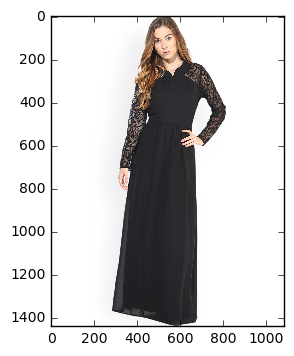

In [17]:
image = Image.open(val_images[6])
print (image.size)
plt.imshow(image) 

(1080, 1440)

In [71]:
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version.
The following packages were automatically installed and are no longer required:
  avahi-utils cuda-7-5 cuda-command-line-tools-7-5 cuda-core-7-5
  cuda-cublas-7-5 cuda-cublas-dev-7-5 cuda-cudart-7-5 cuda-cudart-dev-7-5
  cuda-cufft-7-5 cuda-cufft-dev-7-5 cuda-curand-7-5 cuda-curand-dev-7-5
  cuda-cusolver-7-5 cuda-cusolver-dev-7-5 cuda-cusparse-7-5
  cuda-cusparse-dev-7-5 cuda-documentation-7-5 cuda-driver-dev-7-5
  cuda-license-7-5 cuda-misc-headers-7-5 cuda-npp-7-5 cuda-npp-dev-7-5
  cuda-nvrtc-7-5 cuda-nvrtc-dev-7-5 cuda-runtime-7-5 cuda-samples-7-5
  cuda-toolkit-7-5 cuda-visual-tools-7-5 libcuda1-352 nvidia-352-dev
  nvidia-352-uvm nvidia-opencl-icd-352 python-gnomekeyring python-libxml2
  python-smbc toilet toilet-fonts
Use 'apt-get autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 310 not upgraded.


In [53]:
label_map_file = '/data2/image_attributes/data/myntra_data/' + article_type + '/' + \
article_type + '_' + attribute + '/' + article_type + '_' + attribute + '_label_map.txt'
with open(label_map_file) as json_data:
    label_map = json.load(json_data)  
label_map

{u'Above Knee': 1,
 u'Calf length': 5,
 u'Knee Length': 2,
 u'Maxi': 0,
 u'Midi': 3,
 u'Thigh Length': 4}

In [ ]:
if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    parser = optparse.OptionParser()
    parser.add_option(
        '-g', '--gpu',
        help="use gpu mode",
        action='store_true', default=False)

    opts, args = parser.parse_args()

    model_details = MODEL_PATH_DICT
    # Initialize classifier + warm start by forward for allocation
    caffe_model = ModelClassifier(model_def_file=model_details['deployPath'],
                                  pretrained_model_file=model_details['modelPath'],
                                  mean_file=model_details['meanFilePath'], raw_scale=255.,
                                  class_labels_file=model_details['mapFilePath'], image_dim=256, gpu_mode=opts.gpu)

    caffe_model.net.forward()
    logging.info('Initialized the classfier')
    get_conf_matrix(caffe_model)

In [1]:
import glob
import pickle 
import os
evaluation_for = "test"
article_type= "dresses"
attribute = "shape"
#epoch_1_batch32_ckpt.pth.tar
list_of_files = glob.glob('/rapid_data/myntra/myntra_data/'+article_type+'/'+article_type+'_'+attribute+'/checkpoints_resnet34/*.tar') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print latest_file

/rapid_data/myntra/myntra_data/dresses/dresses_shape/checkpoints_resnet34/epoch_23_batch32_ckpt.pth.tar


In [2]:
predictionStorePath='/rapid_data/myntra/myntra_data/'+article_type+'/'+article_type+'_'+attribute+'/evaluation/'+evaluation_for+'/parallel_check/predictions.txt'
if os.path.exists(predictionStorePath) :
        print("using previous predicted file...")
        with open(predictionStorePath, 'r') as f:
            #all_results = f.read().splitlines()
            all_results = pickle.load(f)

using previous predicted file...


ImportError: No module named torch._utils

In [27]:
from collections import Counter
c = Counter(map(lambda x: x[1], all_results))

In [28]:
c

Counter({0: 1895,
         1: 3,
         2: 4094,
         3: 2358,
         4: 67,
         5: 1443,
         6: 334,
         7: 554,
         13: 1})

In [3]:
val = (True, 2, [[6.1781555e-03, 2.7027801e-03, 4.9199021e-01, 6.4556459e-03,
        7.3091662e-03, 1.6933797e-02, 4.3504742e-01, 3.9536799e-03,
        2.3158353e-03, 7.8792889e-03, 4.4802215e-04, 8.9516798e-03,
        2.8605682e-03, 4.5902347e-03, 2.3834102e-03]])
val

(True,
 2,
 [[0.0061781555,
   0.0027027801,
   0.49199021,
   0.0064556459,
   0.0073091662,
   0.016933797,
   0.43504742,
   0.0039536799,
   0.0023158353,
   0.0078792889,
   0.00044802215,
   0.0089516798,
   0.0028605682,
   0.0045902347,
   0.0023834102]])

In [ ]:
val[]